** First import all libraries **

In [71]:
%pylab
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(style="white")

# import library for ML
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/ashrafulislam/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data Acquision and Cleaning
---
---
We will describe data collection and cleaning part here. We have collected two datasets, one for **heart-disease-death** and another one for **Social Vulnerability Index (SVI)**.

### Heart rate disease dataset
---

### Read data
This data has several columns. However, for our purpose, the final data will have three columns: `COUNTY`, `STATE`, `RATE` (death rate from heart disease per 10,000 people)

In [72]:
hd_filename = "./Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County.xls"
df_xls = pd.read_excel(hd_filename)  # original dataset
# get data for 'overall' gender and 'overall' ethnicity
df_xls = df_xls[(df_xls['Stratification1']=='Overall') & (df_xls['Stratification2']=='Overall')]
print("Column names in the original dataset")
print(df_xls.columns)

Column names in the original dataset
Index(['Year', 'LocationAbbr', 'LocationDesc', 'GeographicLevel', 'DataSource',
       'Class', 'Topic', 'Data_Value', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'TopicID', 'LocationID', 'Location 1'],
      dtype='object')


### Clean data

In [73]:
df = pd.DataFrame()
df['COUNTY'] = df_xls.LocationDesc.apply(lambda name: name.lower().replace("county", "").strip())
df['STATE'] = df_xls.LocationAbbr
df['RATE'] = df_xls.Data_Value
df_hr = df.dropna()  # clean data
df_hr = df_hr.sort_values(by=['STATE', 'COUNTY'])
df.head()


,COUNTY,STATE,RATE
0,aleutians east,AK,105.3
1,aleutians west,AK,211.9
2,anchorage,AK,257.9
3,bethel,AK,351.6
4,bristol bay,AK,NaN


### SVI data
---

### Read data

In [74]:
svi_filename = "./SVI2014_US_CNTY.csv"
df_xls_svi = pd.read_csv(svi_filename)

### Clean Data

This is a large dataset. The metrics that will be in the analysis: 

1. `EP_POV` (person below povert estimate), 
2. `EP_UNEMP` (civilian unemployed), 
3. `EP_PCI` (per capita income), 
4. `EP_NOHSDP` (person with no high school diploma), 
5. `EP_AGE65` (person age 65+), 
6. `EP_AGE17` (17+), 
7. `EP_SNGPNT` (single parent household with one children), 
8. `EP_MINRTY` (minority estimate except white, non-hispanic), 
9. `EP_LIMENG` (person who speaks English less than well), 
10. `EP_NOVEH` (household with no vehicle), 
11. `EP_GROUPQ` (person in group quarters), 
12. `E_TOTPOP` (total population).

All values are in percentage `[0-100]` except `E_TOTPOP` and `EP_PCI`.

In [75]:
columns_to_chose = ["ST_ABBR", "COUNTY", "E_TOTPOP", "EP_POV", "EP_UNEMP", "EP_PCI", "EP_NOHSDP", "EP_AGE65", "EP_AGE17", "EP_SNGPNT", "EP_MINRTY", "EP_LIMENG", "EP_NOVEH", "EP_GROUPQ"]
df_svi = df_xls_svi.filter(columns_to_chose).dropna()
df_svi['COUNTY'] = df_xls_svi.COUNTY.apply(lambda name: name.lower().replace("county", "").strip())
df_svi = df_svi.rename(columns={"ST_ABBR": "STATE"})
df_svi = df_svi.sort_values(by=['STATE', 'COUNTY'])
df_svi.head()



,STATE,COUNTY,E_TOTPOP,EP_POV,EP_UNEMP,EP_PCI,EP_NOHSDP,EP_AGE65,EP_AGE17,EP_SNGPNT,EP_MINRTY,EP_LIMENG,EP_NOVEH,EP_GROUPQ
67,AK,aleutians east,3296.0,16.4,2.2,27122.0,20.5,5.1,11.3,14.9,86.2,13.3,21.5,57.5
68,AK,aleutians west,5650.0,8.9,2.7,32700.0,14.5,5.7,16.3,9.9,71.1,9.1,15.9,30.4
69,AK,anchorage,298178.0,8.3,6.9,36508.0,7.5,8.1,25.4,11.0,38.9,2.4,6.0,2.8
70,AK,bethel,17576.0,23.7,17.3,18875.0,19.8,6.2,35.9,16.6,88.7,3.4,57.0,2.0
71,AK,bristol bay,995.0,7.2,5.5,37012.0,8.8,6.7,26.5,12.3,46.5,0.0,9.8,0.7


### Show correlation among different metrics

Here, we show correlation among different columns of the dataset

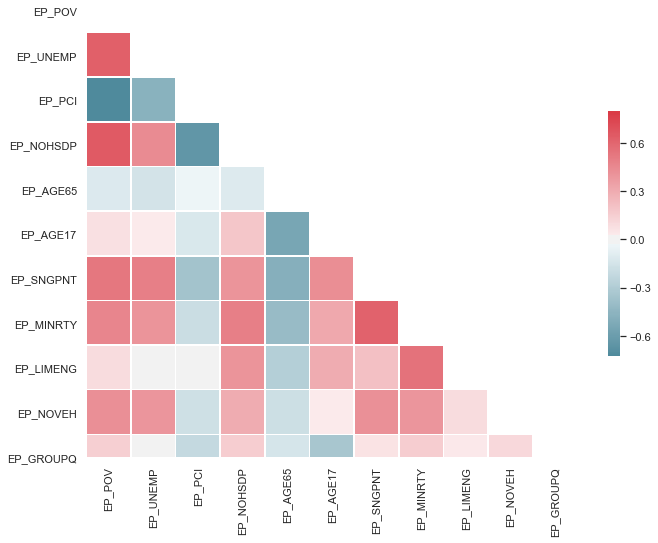

In [76]:
df_svi_ep = df_svi.filter(regex='EP') / 100.  # normalize
corr = df_svi_ep.corr()
# plot correlation matrix
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
plt.figure(1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the heatmap, we can have some interesting findings:

- There is high correlation between EP_UNEMP and EP_POV, *i.e.*, poverty and unemploymet rate highly correlates. Same goes for poverty vs no-high-school-diploma.
- High correlation between minority population (EP_MINRTY) and limited English (EP_LIMENG), minority population and no vehicle in household(EP_NOVEH), minority population and single parent household (EP_SNGPNT)
- High correlation between single parent household and poverty, which is interesting, as this is generally reversed in developing nations.

### Merge two datasets

In this section, we merge two datasets together. We only filter those values that are common in both datasets.


In [77]:
# Merge two different datasets along 'STATE' and 'COUNTY'
df_merge = pd.merge(df_hr, df_svi, on=['COUNTY', 'STATE'])
df_merge = df_merge.dropna()

### Correlation with Heart-disease-death-rate

Here, we show the correlation between different factors in SVI with heart-disease-death-rate

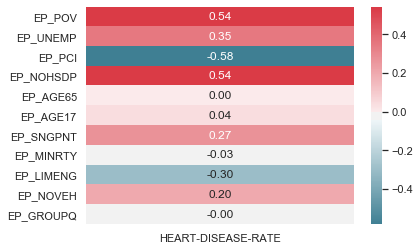

In [78]:
# Plot heatmap of heart-rate disease vs EP_*

df_merge_ep = df_merge.filter(regex='EP') / 100.  # normalize
corr = df_merge_ep.corrwith(df_merge.RATE)
f, ax = plt.subplots()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
corr = pd.DataFrame(corr, columns=["HEART-DISEASE-RATE"])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, ax=ax)
plt.autoscale()



Some findings from the heat-map:

- Heart-disease-death-rate highly correlates with **poverty** and **no-high-school-diploma-household** 
- Heart-disease-death-rate inversely correlates with **per-capita-income** and **limited-English-speaking-ability**

# Machine Learning Part
---

## Data Preprocessing
---

In [79]:
# Convert heart rate disease values to categorical values
df_merge['RATE_CAT'] = pd.cut(df_merge.RATE.values, bins=[0, 320, 420, 800],
            labels=["low", "medium", "high"])
df_merge['RATE_CAT'].value_counts(sort=False)

low       373
medium    483
high      254
Name: RATE_CAT, dtype: int64

In [80]:
# get feature and target
feature_columns = ["E_TOTPOP", "EP_POV", "EP_UNEMP", "EP_PCI", "EP_NOHSDP", "EP_AGE65", "EP_AGE17", "EP_SNGPNT", "EP_MINRTY", "EP_LIMENG", "EP_NOVEH", "EP_GROUPQ"]
target_column = ["RATE_CAT"]
X = df_merge.loc[:, feature_columns]
X_scale = preprocessing.scale(X)
Y = df_merge.loc[:, target_column].values.ravel()
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)
n_target = len(np.unique(Y))


In [81]:
# test train split
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y, test_size=0.3, random_state=1)
print("train sample: ", X_train.shape[0])
print("test sample: ", X_test.shape[0])


train sample:  777
test sample:  333


### SVM Classification
---

In [82]:
## SVM model

clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_train, Y_train)
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [83]:
y_pred = clf.predict(X_test)
_score = accuracy_score(Y_test, y_pred, normalize=True)
print("Accuracy :", _score)

Accuracy : 0.6636636636636637


From SVM classifier, we can get around **67%** classification accuracy

In [84]:
# helper function

from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.autoscale()
    return ax

### Plot Confusion-matrix

Normalized confusion matrix
[[0.62162162 0.01351351 0.36486486]
 [0.00884956 0.74336283 0.24778761]
 [0.20547945 0.17123288 0.62328767]]


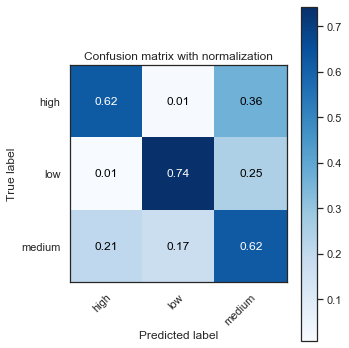

In [85]:

plot_confusion_matrix(y_pred, Y_test, classes=le.classes_, normalize=True,
                      title='Confusion matrix with normalization')


### K-NN Classifier
---

In [86]:


clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
_score = accuracy_score(Y_test, y_pred, normalize=True)
print("Accuracy : ", _score)


Accuracy :  0.6636636636636637


In [87]:

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)
_score = accuracy_score(Y_test, y_pred, normalize=True)
print("Accuracy : ", _score)

Accuracy :  0.5255255255255256


#### SVM and K-NN seem to work best for this problem